# Multi-Objective Evolutionary Algorithm
As five scenarios have been identified by the PRIM analysis, next Multi-Objective Evolutionary Algorithms (MOEAs) can be utilized to investigate the scenarios under multiple policies. The goal of this analysis is to obtain different policies that work best for the worst scenarios. The epsilon values were investigated in the notebook 'Epsilon_investigation.ipynb'. The first step is ensuring all the correct packages are installed. 

In [1]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EMA Workbench imports
import ema_workbench
from ema_workbench import (
    Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
    ema_logging, Constant, Scenario, HypervolumeMetric,
    GenerationalDistanceMetric, EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric, SpacingMetric, Constraint)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress

# Custom problem formulation import
from problem_formulation import get_model_for_problem_formulation

# Running the optimization

We will start by running the optimization which entails the following: 
1. **Set Up Logging**: Initialize logging to monitor the progress and debug information during the execution of the optimization process.
2. **Load Model and Scenarios**: Load the model configured for problem formulation 6 and read the selected scenarios from a CSV file.
3. **Create Scenario Objects**: Convert the data from the CSV file into `Scenario` objects that can be used by the EMA Workbench.
4. **Define Optimization Parameters**: Specify the epsilon values for the epsilon constraint method and the number of function evaluations (nfe) for the optimization.
5. **Run Optimization**: Execute the optimization process. This will generate results and convergence metrics, which will be saved to CSV files.
6. **Load and Analyze Results**: Load the optimization results from the archive files and focus on the outcomes of interest.
7. **Visualize Results**: Generate parallel coordinates plots for the outcomes of interest. These plots will be saved as image files for further analysis.


In [2]:
def run_optimization(epsilon, nfe, scenarios, model):
    """
    Run optimization using the EMA Workbench.

    Parameters:
    epsilon (list): The epsilon values for the optimization.
    nfe (int): The number of function evaluations.
    scenarios (list): List of scenarios to be evaluated.
    model: The model to be used for optimization.

    Returns:
    tuple: A tuple containing results and convergences.
    """
    # Initialize lists to store results and convergence metrics
    results = []
    convergences = []

    # Use MultiprocessingEvaluator for parallel processing
    with MultiprocessingEvaluator(model) as evaluator:
        # Iterate over each scenario
        for scenario in scenarios:
            # Perform optimization three times for each scenario
            for i in range(3):
                # Define convergence metrics
                convergence_metrics = [
                    ArchiveLogger(
                        "./archives",
                        [l.name for l in model.levers],
                        [o.name for o in model.outcomes],
                        base_filename="optimization.tar.gz",
                    ),
                    EpsilonProgress(),
                ]

                # Run the optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario,
                )

                # Create result directory if it does not exist
                result_dir = "./archives"
                os.makedirs(result_dir, exist_ok=True)
                
                # Save the results and convergence metrics to CSV files
                result.to_csv(os.path.join(result_dir, f"result__scen{scenario.name}__seed{i}.csv"))
                pd.DataFrame(convergence).to_csv(os.path.join(result_dir, f"convergence__scen{scenario.name}__seed{i}.csv"))

                # Append the results and convergence metrics to the lists
                results.append(result)
                convergences.append(convergence)
    
    # Return the results and convergence metrics
    return results, convergences

In [3]:
def load_results_from_files(directory):
    """
    Load optimization results from CSV files in a specified directory.

    Parameters:
    directory (str): The directory containing the result files.

    Returns:
    DataFrame: A concatenated DataFrame containing all the results.
    """
    # Initialize an empty list to store the individual DataFrames
    results = []

    # Iterate over each file in the specified directory
    for file_name in os.listdir(directory):
        # Check if the file name starts with 'result__' and ends with '.csv'
        if file_name.startswith('result__') and file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(os.path.join(directory, file_name))
            # Append the DataFrame to the results list
            results.append(df)

    # Concatenate all the individual DataFrames into a single DataFrame
    all_results = pd.concat(results)
    
    # Return the concatenated DataFrame
    return all_results

[MainProcess/INFO] pool started with 8 workers
10378it [05:30, 31.38it/s]                                                     
[MainProcess/INFO] optimization completed, found 108 solutions
10418it [05:35, 31.06it/s]                                                     
[MainProcess/INFO] optimization completed, found 116 solutions
10372it [05:34, 31.01it/s]                                                     
[MainProcess/INFO] optimization completed, found 102 solutions
10636it [05:47, 30.59it/s]                                                     
[MainProcess/INFO] optimization completed, found 184 solutions
10526it [05:48, 30.24it/s]                                                     
[MainProcess/INFO] optimization completed, found 143 solutions
10656it [05:52, 30.23it/s]                                                     
[MainProcess/INFO] optimization completed, found 161 solutions
10466it [05:40, 30.69it/s]                                                     
[MainProcess/IN

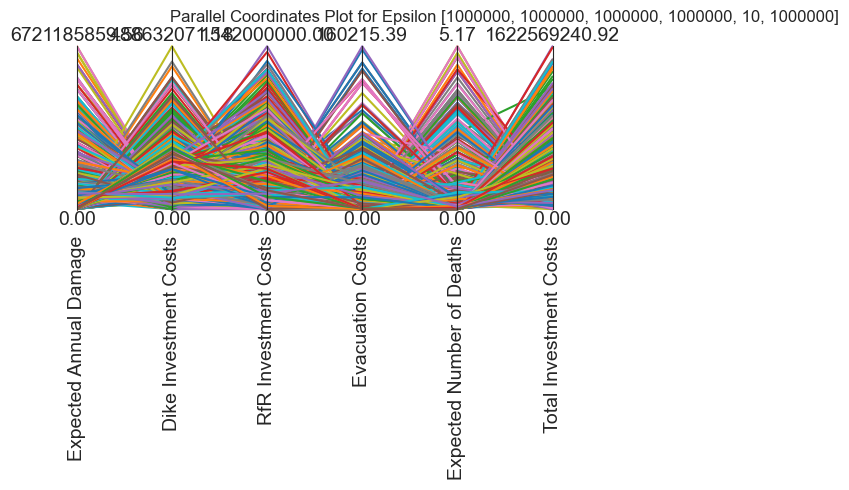

In [4]:
if not os.path.exists('archives'):
    os.makedirs('archives')
    
if __name__ == '__main__':
    # Set up logging to stderr with INFO level
    ema_logging.log_to_stderr(ema_logging.INFO)

    # Get the model and steps for problem formulation 6
    model, steps = get_model_for_problem_formulation(6)

    # Load scenarios from a CSV file
    scenarios_df = pd.read_csv("./data/selected_scenarios.csv")

    # Initialize a list to store scenarios
    scenarios = []
    
    # Iterate over each row in the scenarios dataframe to create Scenario objects
    for index in range(scenarios_df.shape[0]):
        scenario = {}
        for column in scenarios_df:
            if (column == 'Run ID') or (column=='run_id'):
                continue
            # Update the scenario dictionary with column values
            scenario.update({column: scenarios_df.loc[index, column]})

        # Create an EMA Workbench Scenario object
        ema_scenario = Scenario(scenarios_df.loc[index, 'Run ID'], **scenario)
        # Append the scenario to the list
        scenarios.append(ema_scenario)

    # Define epsilon values for the optimization (if statement used for testing multiple epsilon values)
    epsilon_values = [
        [1000000, 1000000, 1000000, 1000000, 10, 1000000]
    ]
    # Set the number of function evaluations
    nfe = 10000

    # Iterate over each set of epsilon values
    for eps in epsilon_values:
        # Run optimization for the given epsilon values and scenarios
        results, convergences = run_optimization(eps, nfe, scenarios, model)

        # Load results from the archive files
        all_results = load_results_from_files("./archives")

        # Define outcomes of interest
        outcomes_of_interest = [
            'Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 
            'Evacuation Costs', 'Expected Number of Deaths', 'Total Investment Costs'
        ]
        # Extract the outcomes from the results
        outcomes = all_results[outcomes_of_interest]

        # Get the limits for the parallel coordinates plot
        limits = parcoords.get_limits(outcomes)
        # Create a ParallelAxes object with the limits
        axes = parcoords.ParallelAxes(limits)
        # Plot the outcomes on the parallel coordinates plot
        axes.plot(outcomes)

        # Set the title and save the plot as an image file
        plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
        plt.savefig(f'parallel_coordinates_eps_{eps}.png')
        plt.show()


As we want to structure the plot better. Replotted with smaller fontsize.

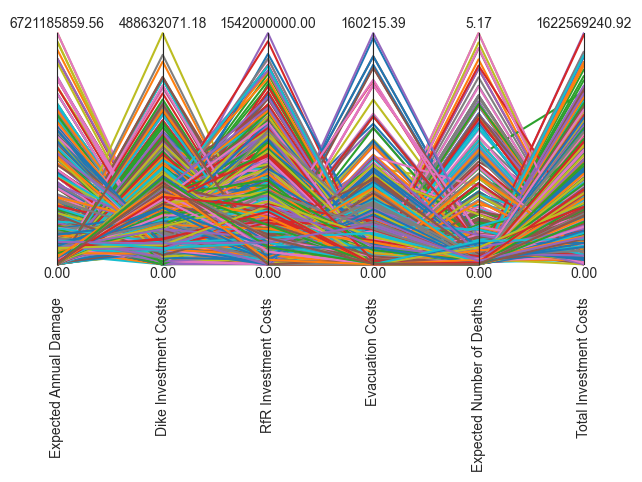

<Figure size 3000x3000 with 0 Axes>

In [37]:

# Get the limits for the parallel coordinates plot
limits = parcoords.get_limits(outcomes)
# Create a ParallelAxes object with the limits
axes = parcoords.ParallelAxes(limits, fontsize=10)

# Plot the outcomes on the parallel coordinates plot
axes.plot(outcomes)

plt.figure(figsize=(30, 30))
# Set the title and save the plot as an image file
plt.show()

# Optimization Results Filtering  and Visualization

In this section, we will perform the following steps:

1. **Count Total Policies**: Determine the total number of policies present in the results.
2. **Filter Dominated Policies**: Identify and retain only the non-dominated policies from the results.
3. **Calculate Metrics**: Compute various metrics for the archives against a reference set.
4. **Plot Metrics**: Visualize the metrics and convergence progress using plots.

### Counting Total Policies

First, we determine the total number of policies in the results:

In [5]:
num_policies = all_results.shape[0]
print(f'There are {num_policies} results.')

There are 2126 results.


# Filtering Dominated Policies
We use the filter_dominated_policies function to filter out the dominated policies from the results. This ensures that we only retain the most effective policies for further analysis to decrease the run time:

In [6]:
def filter_dominated_policies(results):
    """
    Filter out dominated policies from the results.

    Parameters:
    results (DataFrame or list): The results containing policy outcomes.

    Returns:
    DataFrame: A DataFrame containing only the non-dominated policies.
    """
    # Convert results to a DataFrame if it's not already
    if not isinstance(results, pd.DataFrame):
        results = pd.DataFrame(results)

    # Initialize a list to store the indices of non-dominated policies
    non_dominated_indices = []

    # Loop over all pairs of policies
    for i in range(len(results)):
        for j in range(len(results)):
            # Skip if it's the same policy
            if i == j:
                continue

            # Check if policy i is dominated by policy j
            if all(results.iloc[j] <= results.iloc[i]) and any(results.iloc[j] < results.iloc[i]):
                break
        else:
            # If we didn't break from the loop, policy i is not dominated by any other policy
            non_dominated_indices.append(i)

    # Return only the non-dominated policies
    return results.iloc[non_dominated_indices]


In [7]:
# Filter out dominated policies from all results
non_dominated_results = filter_dominated_policies(all_results)

# Get the number of non-dominated policies
num_non_dominated = non_dominated_results.shape[0]

# Output the number of non-dominated policies
num_non_dominated


1854

# Calculating Metrics
Next, we define the calculate_metrics function to compute various metrics such as generational distance, hypervolume, epsilon indicator, inverted generational distance, and spacing. These metrics will help us evaluate the performance of the policies:

In [8]:
def calculate_metrics(archives, reference_set):
    """
    Calculate various metrics for a set of archives against a reference set.

    Parameters:
    archives (dict): A dictionary where keys are the number of function evaluations (nfe) 
                     and values are the corresponding archives.
    reference_set (DataFrame): The reference set used for calculating metrics.

    Returns:
    DataFrame: A DataFrame containing the calculated metrics sorted by nfe.
    """
    # Convert the model to an optimization problem
    problem = to_problem(model, searchover="levers")

    # Initialize the metrics using the reference set and the problem
    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    # Initialize an empty list to store the metrics for each archive
    metrics = []

    # Iterate over each archive in the archives dictionary
    for nfe, archive in archives.items():
        # Calculate the scores for each metric
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        # Append the scores to the metrics list
        metrics.append(scores)

    # Convert the list of metrics to a DataFrame
    metrics = pd.DataFrame.from_dict(metrics)

    # Sort the metrics DataFrame by the number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)

    # Return the sorted metrics DataFrame
    return metrics


# Loading Archives, Cleaning Data, and Visualizing Metrics

In this section, we will perform the following steps:

1. **Load Archives**: Load the archived results from the optimization process.
2. **Clean Data**: Remove unnecessary columns from the data.
3. **Set Reference Set**: Use the non-dominated results as the reference set for metric calculations.
4. **Calculate Metrics**: Compute the various performance metrics for the archives.
5. **Plot Metrics**: Visualize the calculated metrics and convergence progress.

### Loading and Cleaning Archives

First, we load the archived results from the specified directory. We then clean the data by removing any unnecessary columns (such as 'Unnamed: 0'):

In [9]:
archives = ArchiveLogger.load_archives("./archives/optimization.tar.gz")
for key, df in archives.items():
    if 'Unnamed: 0' in df.columns:
        archives[key] = df.drop('Unnamed: 0', axis=1)

In [10]:
if 'Unnamed: 0' in non_dominated_results.columns:
    non_dominated_results = non_dominated_results.drop(columns=['Unnamed: 0'])

We use the plot_metrics function to create plots of the convergence progress and various metrics over the number of function evaluations (nfe). This visualization will help us understand the optimization process and the performance of it:

In [11]:
def plot_metrics(metrics, convergence):
    """
    Plot the convergence and various metrics over the number of function evaluations (nfe).

    Parameters:
    metrics (DataFrame): A DataFrame containing the metrics over nfe.
    convergence (list): A list of convergence objects containing epsilon progress over nfe.
    """
    # Set the style for seaborn plots
    sns.set_style("white")
    
    # Create a figure with 6 subplots arranged vertically, sharing the x-axis
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    # Unpack the axes for easier reference
    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    # Plot epsilon progress for each convergence object on the first subplot
    for conv in convergence:
        ax1.plot(conv.nfe, conv.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")

    # Plot generational distance on the second subplot
    ax2.plot(metrics.nfe, metrics.generational_distance)
    ax2.set_ylabel("Generational Distance")

    # Plot epsilon indicator on the third subplot
    ax3.plot(metrics.nfe, metrics.epsilon_indicator)
    ax3.set_ylabel("Epsilon Indicator")

    # Plot inverted generational distance on the fourth subplot
    ax4.plot(metrics.nfe, metrics.inverted_gd)
    ax4.set_ylabel("Inverted Generational\nDistance")

    # Plot spacing on the fifth subplot
    ax5.plot(metrics.nfe, metrics.spacing)
    ax5.set_ylabel("Spacing")

    # Plot hypervolume on the sixth subplot
    ax6.plot(metrics.nfe, metrics.hypervolume)
    ax6.set_ylabel("Hypervolume")

    # Set the label for the shared x-axis
    ax6.set_xlabel("Number of Function Evaluations (nfe)")

    # Remove the top and right spines from the plots for a cleaner look
    sns.despine(fig)


### Setting Reference Set and Visualizing Metrics

We will use the non-dominated results as the reference set for calculating the metrics. This reference set will help us evaluate the performance of different policies effectively. After calculating the metrics, we will visualize them to gain insights into the optimization process.

1. **Set Reference Set**: Use the non-dominated results as the reference set for metric calculations.
2. **Calculate Metrics**: Compute the various performance metrics for the archives against the reference set.
3. **Plot Metrics**: Visualize the calculated metrics and convergence progress.

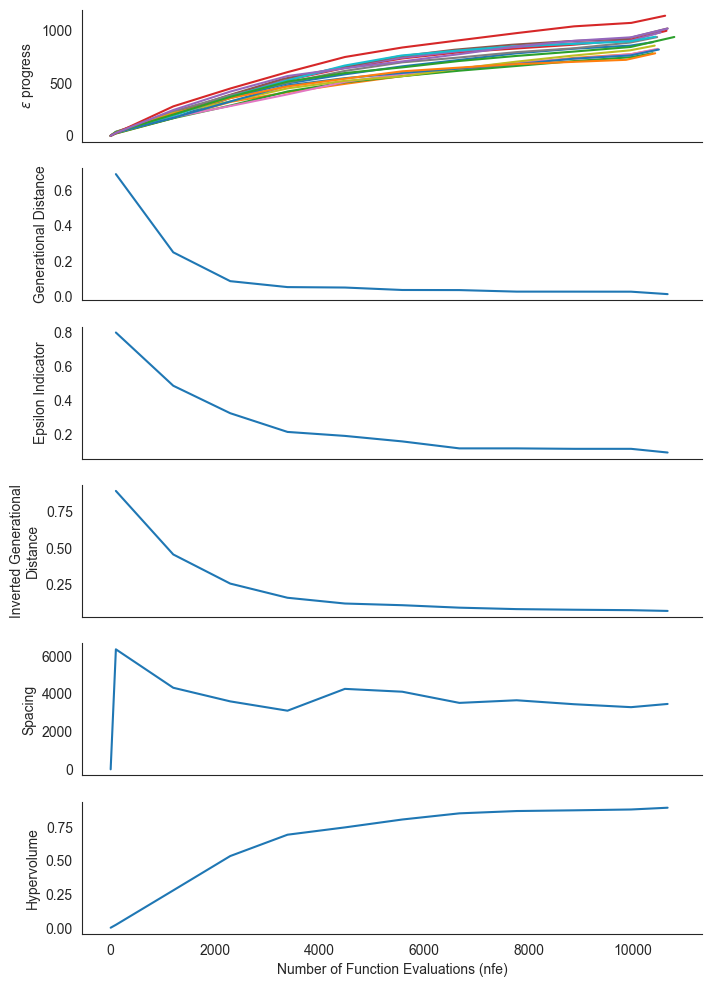

In [12]:
# Set the reference set to the non-dominated results
reference_set = non_dominated_results

# Calculate the metrics using the archives and the reference set
# This evaluates the performance of the policies in the archives against the non-dominated reference set
metrics = calculate_metrics(archives, reference_set)

# Plot the calculated metrics and convergence progress
# This visualizes the metrics over the number of function evaluations (nfe)
plot_metrics(metrics, convergences)

# Display the plots
# This shows the generated plots for the metrics and convergence progress
plt.show()


To determine if the optimization has run for long enough, we can look at the trends in the plotted metrics. Here are a few key observations:

The $\epsilon$ progress is steadily increasing, but there is no clear indication that it is plateauing. This suggests that further optimization might continue to make progress, albeit potentially at a slower rate.

The generational distance decreases sharply at first and then levels off, indicating that the solutions are getting closer to the reference set. The leveling off suggests that additional improvements might be marginal, but the trend hasn't completely flattened.

The epsilon indicator shows a decreasing trend but is also leveling off. This suggests diminishing returns with additional function evaluations.

Similar to the generational distance, this metric decreases and levels off, indicating that the optimization is approaching a stable set of solutions.

The spacing metric is increasing, indicating improved uniformity in the solution distribution. This metric might still benefit from further optimization to achieve a more uniform spread.

The hypervolume is increasing, indicating that the Pareto front is expanding and covering more of the objective space. While it shows growth, the rate of increase appears to be slowing down, suggesting that the optimization is nearing its potential.
Conclusion


Thus, the generational distance, epsilon indicator, and inverted generational distance are leveling off, suggesting that the solutions are converging and additional improvements may be marginal. The $\epsilon$ progress and hypervolume are still increasing, albeit at a slower rate, indicating that further optimization could still yield benefits.

While there is evidence that the optimization is nearing convergence, some metrics indicate potential for further improvement. However, considering the time and computational resources available and the fact that the increase in performance metrics is occurring at a much slower rate, indicating that the additional computational effort required for further optimization may not be justified by the marginal gains. Given the limited time and computational resources, it is not feasible to continue the optimization process further.

Therefore, while some benefits could still be yielded, it is clear that the rate of improvement is slow enough that, when holding computational resources against the potential gains, we have decided to proceed with the analysis using the current results.

# Filtering policies
As safety is our number one priority, we do not want to look at any possibilities of having an expected number of deaths higher than 0. Therefore, we apply a logic only keeping the policies for which the expected number of deaths is 0. 

In [13]:
# Create a boolean Series where 'Expected Number of Deaths' is zero
logical = non_dominated_results['Expected Number of Deaths'] == 0

# Calculate and output the number of policies where 'Expected Number of Deaths' is zero
num_zero_deaths = np.sum(logical)
print(num_zero_deaths)


79


In [14]:
non_dominated_results[logical].head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
9,0,0,1,0,0,0,1,1,1,1,...,5,2,0,0,0.0,1.179182e+08,297900000.0,0.0,0.0,4.158182e+08
21,0,0,0,0,0,0,0,0,0,0,...,0,7,2,0,0.0,2.637349e+08,0.0,0.0,0.0,2.637349e+08
23,0,1,0,0,0,0,1,1,0,0,...,0,3,0,0,0.0,1.222290e+08,267200000.0,0.0,0.0,3.894290e+08
33,0,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0.0,1.086947e+08,509600000.0,0.0,0.0,6.182947e+08
70,0,1,0,1,0,0,1,1,1,1,...,0,0,0,0,0.0,8.758014e+07,758100000.0,0.0,0.0,8.456801e+08


# Final step 
Lastly, we export the found policies to a CSV file so that they can be investigated further. 

In [15]:
# Filter the non-dominated results to get policies where 'Expected Number of Deaths' is zero
policies = non_dominated_results[logical]

# Drop the columns corresponding to outcomes from the policies DataFrame
policies = policies.drop([o.name for o in model.outcomes], axis=1)

# Print the filtered policies DataFrame
print(policies)

# Export the policies DataFrame to a CSV file in the './data' directory
policies.to_csv('./data/policies.csv')

     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
9          0        0        1        0        0        0        1        1   
21         0        0        0        0        0        0        0        0   
23         0        1        0        0        0        0        1        1   
33         0        0        1        0        0        0        0        1   
70         0        1        0        1        0        0        1        1   
..       ...      ...      ...      ...      ...      ...      ...      ...   
48         0        1        0        0        0        0        1        1   
55         0        0        0        0        0        1        1        1   
123        0        0        0        0        0        0        0        0   
8          0        0        0        0        0        0        0        0   
113        0        1        1        0        0        0        1        0   

     2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3